# Group ACE project: Difference between left-wing media and right-wing media in the US

Code for data collection, cleaning/wrangling, analysis, and visualizations;

## 1. Data Collection & Cleaning

In [ ]:
from crawl import SearchEngine
# autoreload
%load_ext autoreload
%autoreload 2

In [ ]:
kargs1 = {'name': 'CNN',                      # name of the news website
          'keyword': 'US',                    # keyword to search
          'startpage': 1,
          'endpage': 20,
          'sleep1': 1,                        # time interval to revisit the page if failed
          'sleep2': 1,                        # time interval to visit the next page if current page is empty
          'sleep3': 1,                        # time interval to reparse the page if failed
          'limit1': 10,                       # number of times to revisit the page if failed, then skip the page
          'limit2': 10,                       # number of times to visit next page if current page is empty, then end the crawler
          'limit3': 3,                        # total number of times to reparse the page if failed, then end the crawler
          'filter_': None,                    # time filter for the news
          'process': False,                   # whether to get the urls in debug
          'parse': False,                     # whether to parse the urls in debug
          'save': False,                      # whether to save the news in debug
          'root': f'../data/test',}                   # root directory to save the news
keywords = open('keywords.txt', 'r').read().split('\n')
print(keywords)

In [ ]:
search = SearchEngine(**kargs1)
search.get_urls(1)
search.get_all_urls()
search.parse()
search.auto(['CNN', 'nypost'] , keywords[:2])

## 2. Embedding Model Training

In [3]:
import json
import os
from collections import Counter

import gensim
import nltk
import pandas as pd
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:

sentences_cnn = []
sentences_nypost = []

counts_general = dict()
counts_cnn = dict()
counts_nypost = dict()
counts_general[0] = 0
counts_cnn[0] = 0
counts_nypost[0] = 0
for fname in os.listdir('./data/nypost/'):
    if len(fname) > 12:
        print(fname)
        df = pd.read_csv(os.path.join('./data/nypost', fname))
        for idx, row in df.iterrows():
            for st in sent_tokenize(str(row['text'])):
                sts_list = gensim.utils.simple_preprocess(st)
                hist = Counter(sts_list)
                for k in hist:
                    counts_general[0] += 1
                    counts_nypost[0] += 1
                    counts_general[k] = hist[k] + counts_general.get(k, 0)
                    counts_nypost[k] = hist[k] + counts_general.get(k, 0)
                sentences_cnn.append(sts_list)


for fname in os.listdir('./data/CNN/'):
    if len(fname) > 12:
        print(fname)
        df = pd.read_csv(os.path.join('./data/CNN', fname))
        for idx, row in df.iterrows():
            for st in sent_tokenize(str(row['text'])):
                sts_list = gensim.utils.simple_preprocess(st)
                hist = Counter(sts_list)
                for k in hist:
                    counts_general[0] += 1
                    counts_cnn[0] += 1
                    counts_cnn[k] = hist[k] + counts_cnn.get(k, 0)
                    counts_general[k] = hist[k] + counts_general.get(k, 0)
                sentences_nypost.append(sts_list)

nypost_gun_page1to10000_timeto.csv
nypost_Trump_page1to10000_timeto.csv
nypost_Biden_page1to10000_timeto.csv
nypost_invasion_page1to5000_timeto.csv
nypost_republic_page1to10000_timeto.csv
nypost_Biden.csv
nypost_immigration.csv
nypost_terror_page1to10000_timeto.csv
nypost_ukraine_page1to10000_timeto.csv
nypost_crime.csv
nypost_UK.csv
nypost_Trump.csv
nypost_Russia.csv
nypost_conflict.csv
nypost_crime_page1to5000_timeto.csv
nypost_US_page1to10000_timeto.csv
nypost_attack_page1to10000_timeto.csv
nypost_violence.csv
nypost_violence_page1to10000_timeto.csv
nypost_terror.csv
nypost_Russia_page1to10000_timeto.csv
nypost_refused.csv
nypost_democratic_page1to10000_timeto.csv
nypost_LGBT_page1to10000_timeto.csv
nypost_immigration_page1to10000_timeto.csv
nypost_fair.csv
nypost_protest.csv
nypost_invasion.csv
nypost_fair_page1to10000_timeto.csv
nypost_UK_page1to10000_timeto.csv
nypost_democratic.csv
nypost_US.csv
nypost_LGBT.csv
nypost_China.csv
nypost_police_page1to10000_timeto.csv
nypost_police

In [3]:
json.dump(counts_general, open(os.path.join('./wv', 'general_word_freq_add.json'), 'w'))
json.dump(counts_nypost, open(os.path.join('./wv', 'nypost_word_freq_add.json'), 'w'))
json.dump(counts_cnn, open(os.path.join('./wv', 'cnn_word_freq_add.json'), 'w'))

In [4]:
opts = {'dims': 100,
        'window': 5,
        'n_cpu': -1,
        'min_count': 30,
        'vocab_size': 10000,
        'sample': 0.0001,
        'n_iter': 30
        }
model = gensim.models.Word2Vec(sentences=sentences_cnn + sentences_nypost,
                               vector_size=opts['dims'],
                               window=opts['window'],
                               workers=opts['n_cpu'],
                               sg=1,
                               hs=0,
                               negative=5,
                               min_count=opts['min_count'],
                               max_final_vocab=opts['vocab_size'],
                               sample=opts['sample'],
                               epochs=opts['n_iter']
                               )
model.save(os.path.join('./wv', 'general_add.model'))

In [5]:
opts = {'dims': 100,
        'window': 5,
        'n_cpu': -1,
        'min_count': 30,
        'vocab_size': 10000,
        'sample': 0.0001,
        'n_iter': 30
        }
model = gensim.models.Word2Vec(sentences=sentences_nypost,
                               vector_size=opts['dims'],
                               window=opts['window'],
                               workers=opts['n_cpu'],
                               sg=1,
                               hs=0,
                               negative=5,
                               min_count=opts['min_count'],
                               max_final_vocab=opts['vocab_size'],
                               sample=opts['sample'],
                               epochs=opts['n_iter']
                               )

model.save(os.path.join('./wv', 'nypost_add.model'))

In [ ]:
opts = {'dims': 100,
        'window': 5,
        'n_cpu': -1,
        'min_count': 30,
        'vocab_size': 10000,
        'sample': 0.0001,
        'n_iter': 30
        }
model = gensim.models.Word2Vec(sentences=sentences_cnn,
                               vector_size=opts['dims'],
                               window=opts['window'],
                               workers=opts['n_cpu'],
                               sg=1,
                               hs=0,
                               negative=5,
                               min_count=opts['min_count'],
                               max_final_vocab=opts['vocab_size'],
                               sample=opts['sample'],
                               epochs=opts['n_iter']
                               )

model.save(os.path.join('./wv', 'cnn_add.model'))

## 3. Model Aligning

In [1]:
import json
import os
import pickle

import gensim
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from sklearn.cluster import KMeans

from align import CCAAligner, get_cca_aligner

In [ ]:
stopWords_nltk = set(stopwords.words('english'))
stopWords_spc = {'those', 'on', 'own', '’ve', 'yourselves', 'around', 'between', 'four', 'been', 'alone', 'off', 'am',
                 'then', 'other', 'can', 'regarding', 'hereafter', 'front', 'too', 'used', 'wherein', '‘ll', 'doing',
                 'everything', 'up', 'onto', 'never', 'either', 'how', 'before', 'anyway', 'since', 'through', 'amount',
                 'now', 'he', 'was', 'have', 'into', 'because', 'not', 'therefore', 'they', 'n’t', 'even', 'whom', 'it',
                 'see', 'somewhere', 'thereupon', 'nothing', 'whereas', 'much', 'whenever', 'seem', 'until', 'whereby',
                 'at', 'also', 'some', 'last', 'than', 'get', 'already', 'our', 'once', 'will', 'noone', "'m", 'that',
                 'what', 'thus', 'no', 'myself', 'out', 'next', 'whatever', 'although', 'though', 'which', 'would',
                 'therein', 'nor', 'somehow', 'whereupon', 'besides', 'whoever', 'ourselves', 'few', 'did', 'without',
                 'third', 'anything', 'twelve', 'against', 'while', 'twenty', 'if', 'however', 'herself', 'when', 'may',
                 'ours', 'six', 'done', 'seems', 'else', 'call', 'perhaps', 'had', 'nevertheless', 'where', 'otherwise',
                 'still', 'within', 'its', 'for', 'together', 'elsewhere', 'throughout', 'of', 'others', 'show', '’s',
                 'anywhere', 'anyhow', 'as', 'are', 'the', 'hence', 'something', 'hereby', 'nowhere', 'latterly', 'say',
                 'does', 'neither', 'his', 'go', 'forty', 'put', 'their', 'by', 'namely', 'could', 'five', 'unless',
                 'itself', 'is', 'nine', 'whereafter', 'down', 'bottom', 'thereby', 'such', 'both', 'she', 'become',
                 'whole', 'who', 'yourself', 'every', 'thru', 'except', 'very', 'several', 'among', 'being', 'be',
                 'mine', 'further', 'n‘t', 'here', 'during', 'why', 'with', 'just', "'s", 'becomes', '’ll', 'about',
                 'a', 'using', 'seeming', "'d", "'ll", "'re", 'due', 'wherever', 'beforehand', 'fifty', 'becoming',
                 'might', 'amongst', 'my', 'empty', 'thence', 'thereafter', 'almost', 'least', 'someone', 'often',
                 'from', 'keep', 'him', 'or', '‘m', 'top', 'her', 'nobody', 'sometime', 'across', '‘s', '’re',
                 'hundred', 'only', 'via', 'name', 'eight', 'three', 'back', 'to', 'all', 'became', 'move', 'me', 'we',
                 'formerly', 'so', 'i', 'whence', 'under', 'always', 'himself', 'in', 'herein', 'more', 'after',
                 'themselves', 'you', 'above', 'sixty', 'them', 'your', 'made', 'indeed', 'most', 'everywhere',
                 'fifteen', 'but', 'must', 'along', 'beside', 'hers', 'side', 'former', 'anyone', 'full', 'has',
                 'yours', 'whose', 'behind', 'please', 'ten', 'seemed', 'sometimes', 'should', 'over', 'take', 'each',
                 'same', 'rather', 'really', 'latter', 'and', 'ca', 'hereupon', 'part', 'per', 'eleven', 'ever', '‘re',
                 'enough', "n't", 'again', '‘d', 'us', 'yet', 'moreover', 'mostly', 'one', 'meanwhile', 'whither',
                 'there', 'toward', '’m', "'ve", '’d', 'give', 'do', 'an', 'quite', 'these', 'everyone', 'towards',
                 'this', 'cannot', 'afterwards', 'beyond', 'make', 'were', 'whether', 'well', 'another', 'below',
                 'first', 'upon', 'any', 'none', 'many', 'serious', 'various', 're', 'two', 'less', '‘ve'}
stopWords_s = stopWords_spc | stopWords_nltk | STOPWORDS

In [ ]:
model_general = gensim.models.Word2Vec.load(os.path.join('./models', 'general_add.model'))

vocab = list(sorted(list(model_general.wv.index_to_key)))
vocab = [w for w in vocab if w not in stopWords_s]
mtx = np.vstack([model_general.wv[w] for w in vocab])

clustering = KMeans(n_clusters=300).fit(mtx)
res = {}
t_align = {}
for c, w in zip(clustering.labels_, vocab):
    t_align[w] = c
    c = str(c)
    if c not in res:
        res[c] = []
    res[c].append(w)
json.dump(res, open(os.path.join('./models', 'news_clustering_add.tpc'), 'w'))
pickle.dump(t_align, open(os.path.join('./models', 't_align.pkl'), 'wb'))

In [ ]:
c_num = []
c_words = []
c_name = []
for k in res.keys():
    c_num.append(k)
    c_words.append(res[k])
    c_name.append([])
pd.DataFrame({'id': c_num, 'name': c_name, 'words': c_words}).to_csv('./news_topics_add.csv')

In [ ]:
model_general=gensim.models.Word2Vec.load(os.path.join('./models', 'general_add.model'))
model_nypost = gensim.models.Word2Vec.load(os.path.join('./models', 'nypost_add.model'))
model_cnn = gensim.models.Word2Vec.load(os.path.join('./models', 'cnn_add.model'))

In [ ]:
shared_vocab = set(model_nypost.wv.key_to_index).intersection(set(model_cnn.wv.key_to_index)).intersection(set(model_general.wv.key_to_index))
stopWords = list(stopWords_s & shared_vocab)

In [ ]:
aligner_cnn = get_cca_aligner(model_cnn, model_general, stopWords)
pickle.dump(aligner_cnn, open(os.path.join('./models', 'align_cnn_add.pkl'), 'wb'))
aligner_nypost = get_cca_aligner(model_nypost, model_general, stopWords)
pickle.dump(aligner_nypost, open(os.path.join('./models', 'align_nypost_add.pkl'), 'wb'))

## Data Analysis: Topic Description

#### 1. Word Cloud

In [ ]:
from analysis import Word_Cloud
kargs2 = {'medias': ['CNN', 'nypost'],                  # medias to include
          'keywords': keywords,                         # keywords to include
          'root': '../data',                               # root directory to load the news
          'limit': 1000,                                # number of news to load
          'custom_stopwords':open('custom_stopwords.txt', 'r').read().split('\n'),}  # add custom stopwords
kargs2['custom_stopwords']

In [ ]:
wc = Word_Cloud(**kargs2)
wc.show()

#### 2. Word CLuster Analysis

In [4]:
from gensim import models,corpora
import pyLDAvis
import pyLDAvis.gensim_models
from analysis import get_lemmas

In [18]:
# get dataframe composed of all csvs in CNN folder
csvs = [x for x in os.listdir('./data/CNN/') if x.endswith('.csv')]
fns = [os.path.splitext(os.path.basename(x))[0] for x in csvs]
topics=[]
for i in fns:
    topics.append(i.split('_')[1])
d = {}
for i in range(len(fns)):
    d[topics[i]] = pd.read_csv(os.path.join('./data/CNN',csvs[i]))


In [20]:
# get pyLDAvis visualizations for all topic models under CNN
cnn_topics=[]
ps = []
for i in fns:
    cnn_topics.append(i.split('_')[1])

for i in cnn_topics:
    model = models.ldamodel.LdaModel.load('./topicmodeling/models/{}CNN.model'.format(i))
    topics = model.print_topics(num_words=20)
    for topic in topics:
        print(topic)
    lemmas = d[i]['text'].apply(get_lemmas)
    dictionary = corpora.Dictionary.load('./topicmodeling/models/{}CNN.model.id2word'.format(i))
    corpus = [dictionary.doc2bow(text) for text in lemmas]
    pyLDAvis.enable_notebook()
    p = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
    ps.append(p)
    print(i+'done')

In [19]:
#import nypost data
ny_csvs = [x for x in os.listdir('./data/nypost/') if x.endswith('.csv')]
fns = [os.path.splitext(os.path.basename(x))[0] for x in ny_csvs]
ny_topics=[]
for i in fns:
    ny_topics.append(i.split('_')[1])
ny_d = {}
for i in range(len(fns)):
    ny_d[ny_topics[i]] = pd.read_csv(os.path.join('./data/nypost',ny_csvs[i]))

In [ ]:
# get pyLDAvis visualizations for all topic models under nypost
ny_topics=[]
ps_ny = []
for i in fns:
    ny_topics.append(i.split('_')[1])
for i in cnn_topics:
    model = models.ldamodel.LdaModel.load('./topicmodeling/models/{}nypost.model'.format(i))
    topics = model.print_topics(num_words=20)
    for topic in topics:
        print(topic)
    lemmas = d[i]['text'].apply(get_lemmas)
    dictionary = corpora.Dictionary.load('./topicmodeling/models/{}nypost.model.id2word'.format(i))
    corpus = [dictionary.doc2bow(text) for text in lemmas]
    pyLDAvis.enable_notebook()
    p = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
    ps_ny.append(p)
    print(i+'done')

## Data Analysis: Content Coverage & Ideological Context

In [ ]:
forward_cnn = pickle.load(open(os.path.join('./models', 'align_cnn_add.pkl'), 'rb'))
forward_nypost = pickle.load(open(os.path.join('./models', 'align_nypost_add.pkl'), 'rb'))
t_align=pickle.load(open(os.path.join('./models', 't_align.pkl'), 'rb'))

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from align import research_topic

topics = ["attack", "Biden", "black", "China", "conflict", "crime", "democratic", "fair", "gun", "immigration",
          "invasion", "LGBT", "police", "protest", "refused", "republic", "Russia", "terror", "Trump", "UK", "ukraine",
          "US", "violence", "war"]

In [ ]:

t_js_list = []
t_cos_list = []
mean_list = []
t_cnn = []
t_nypost = []

for t in topics:
    print(t)
    a, b, c, d, e = research_topic(t,t_align,forward_cnn,forward_nypost,model_general,model_cnn,model_nypost)
    t_js_list.append(a)
    t_cos_list.append(b)
    mean_list.append(c)
    t_cnn.append(d)
    t_nypost.append(e)

In [ ]:
pd.DataFrame({
    'mean_simi': mean_list,
    'JS_div': t_js_list,
    'Cos_div': t_cos_list,
    't_cnn': t_cnn,
    't_nypost': t_nypost
},
    index=topics
).to_csv('./records_add.csv',index=False)

In [7]:
other = [1, 2, 3, 6, 7, 9, 11, 15, 16, 18, 19, 21]
war = [10, 17, 20, 23]
violence = [0, 4, 5, 8, 12, 13, 14, 22]

df = pd.read_csv('./records.csv')

Text(0, 0.5, 'Ideological context diversity')

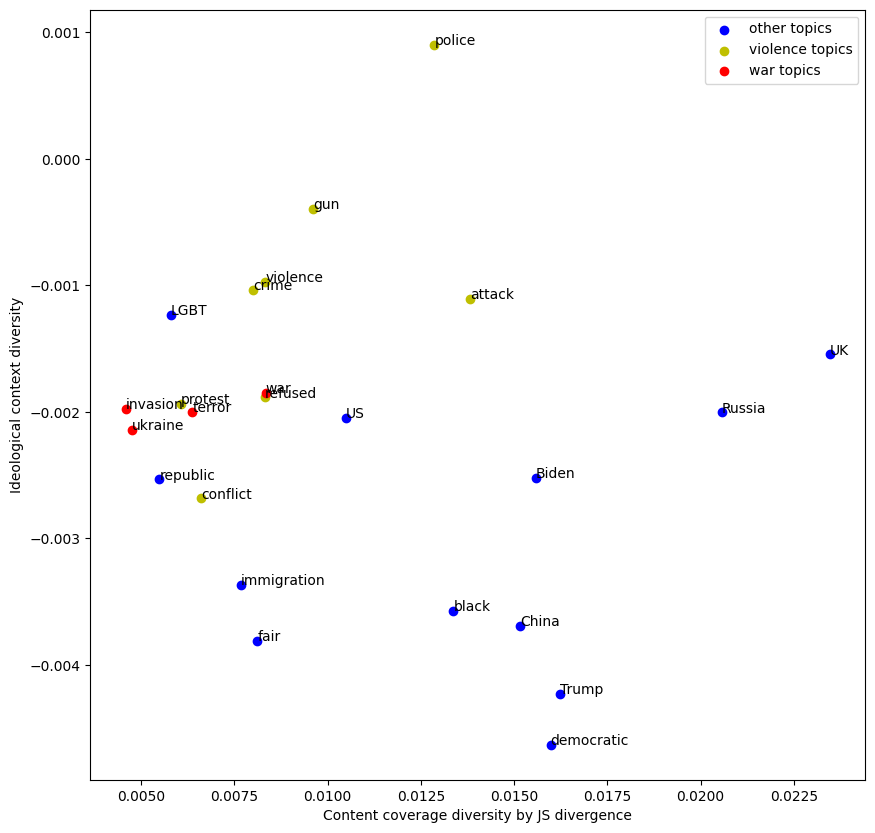

In [12]:
plt.figure(figsize=[10, 10])
plt.scatter(np.array(df.iloc[other]['JS_div']), -np.array(df.iloc[other]['mean_simi']), c='b', label='other topics')
plt.scatter(np.array(df.iloc[violence]['JS_div']), -np.array(df.iloc[violence]['mean_simi']), c='y',
            label='violence topics')
plt.scatter(np.array(df.iloc[war]['JS_div']), -np.array(df.iloc[war]['mean_simi']), c='r', label='war topics')
plt.legend()
for i in range(len(topics)):
    plt.annotate(topics[i], (df['JS_div'][i], -df['mean_simi'][i]))
plt.xlabel('Content coverage diversity by JS divergence')
plt.ylabel('Ideological context diversity')